# Radial Wavefunctions and Quantum Defects

In this tutorial we show how to access quantum defects and wavefunctions, which are used for the computation of matrix elements, using the Python API.  Some aspects of this are discussed in Appendix A of the pairinteraction paper [J. Phys. B: At. Mol. Opt. Phys. 50, 133001 (2017)](https://doi.org/10.1088/1361-6455/aa743a).

This feature is mostly used internally and therefore the interfaces are not so user-friendly.

Ahead of our Python code, we call an IPython magic function to make the output of plotting commands displayed inline within the notebook.

In [1]:
%matplotlib inline

Our code starts with loading the required modules for the computation. It is irrelevant whether we use the `pireal` or `picomplex` modules here, because we do not calculate any matrix elements.

In [2]:
# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# pairinteraction :-)
from pairinteraction import pireal as pi

Keep in mind that pairinteraction is a **Rydberg** interaction calculator.  All techniques presented below work well for the high-$n$ states of Rydberg atoms, but fail miserably for low-lying states.

While the pairinteraction software normally uses the unit system described in the [introduction](https://pairinteraction.github.io/pairinteraction/sphinx/html/introduction.html#units), for the wavefunction it has proven advantageous to perform the calculation in atomic units, i.e. all units below are atomic units (in contrast to the presentation in Appendix A of the [pairinteraction paper](https://doi.org/10.1088/1361-6455/aa743a), where we use SI units throughout).

## Coulomb wavefunctions

Using non-relativistic quantum defect theory it is possible to find radial wavefunctions.  Therefore the Schrödinger equation is solved for a *given* energy eigenvalue, which results in modified radial wavefunctions with an effective (non-integer) quantum number $n^*$.  The derivation is discussed in more detail in M. J. Seaton, [Reports on Progress in Physics 46, 167 (1983)](http://dx.doi.org/10.1088/0034-4885/46/2/002) (around equation 2.77).

$$
  r\;\Psi^{\text{rad}}_{n^*l}(r) = \frac{1}{\sqrt{n^{*2} \Gamma(n^*+l+1) \Gamma(n^*-l)}}
  W_{n^*,l+1/2}\left( \frac{2 r}{n^*} \right).
$$

where $\Gamma(z)$ is the Gamma function and $W_{k,m}(z)$ is the so-called Whittaker function.  These wavefunctions are highly accurate for large distances and have the correct binding energy.  You can access these wavefunctions in pairinteraction using the `Whittaker` class.

## Numerov's method and model potentials

### Model potentials

Another method to determine the radial wavefunctions is by solving the Schrödinger equation numerically using an *effective* Coulomb potential.  The so-called model potential is usually decomposed into three contributions

$$
  V_{\text{mod}}(r) = V_{\text{C}}(r) + V_{\text{P}}(r) + V_{\text{s.o.}}(r).
$$

The first term is the charge contribution resulting from the charged core which is screened by the filled electron shells

$$
  % (18a) in Dalgarno1994
  V_{\mathrm{C}}(r) = - \frac{1 + (Z-1)\mathrm{e}^{-\alpha_1 r} - r(\alpha_3+\alpha_4 r)\mathrm{e}^{-\alpha_2 r}}{r},
$$

with coefficients $\alpha_{1,2,3,4}$ depending on the atomic species and the orbital angular momentum $l$.  These coefficients are provided with pairinteraction in an embedded database.  It is possible to substitute these coefficients with your own at runtime.

For the core polarization, only the leading dipole term is considered, which results in:

$$
  V_{\mathrm{P}}(r) = -\frac{\alpha_d}{2 r^4} \left[ 1 - \mathrm{e}^{-(r/r_c)^6} \right].
$$

Here, $\alpha_d$ is again the core dipole polarizability and $r_c$ is the effective core size, obtained by comparing the numerical solutions with the experimentally observed energy levels.

In addition to these two terms, we add an effective expression for the spin-orbit interaction

$$
  V_{\mathrm{s.o.}}(r > r_c) = \frac{2 \alpha}{r^3} \mathbf{l}\cdot\mathbf{s} = \frac{\alpha}{r^3} [j(j+1) - l(l+1) - s(s+1)].
$$

where $\alpha\approx1/137$ is the fine-structure constant.

### Numerov's method

Numerov's method can be used to solve differential equations of the form

$$
  \frac{d^2 y}{d x^2} + g(x) y(x) = 0.
$$

The iterative solution can be achieved as follows:

$$
  y_{n+1} \left( 1 - \frac{h^2}{12} g_{n+1} \right)
  = \left( 2 + \frac{5 h^2}{6} g_{n} \right) y_{n}
  - \left( 1 - \frac{h^2}{12} g_{n-1} \right) y_{n-1}
  + \mathcal{O}(h^6).
$$

where $y_{n}=y(x_{n})$, $g_{n}=g(x_{n})$, $s_{n}=s(x_{n})$, and $h=x_{n+1}-x_{n}$.

To save space it is useful to reduce the sampling towards large distances from the core as the periods of osciallations become longer and longer.  To this end we introduce the square root scaling:

$$
   x = \sqrt{r} \;,\quad X^{\text{rad}}_{nlj}(x) = x^{3/2} \Psi^{\text{rad}}_{nlj}(r).
$$

This scaling keeps the number of grid points between nodes of the wave function constant.  In this scaling the $g(r)$ in Numerov's method is given by

$$
  g(r) = \frac{(2 l + 1/2)(2 l + 3/2)}{r} + 8 r (V_{\text{mod}}(r) - E).
$$

We integrate the equation from outside to inside.  Since the wavefunction has to decay to zero at infinity we choose $y_0 = 0$. Now depending on the number of nodes of wavefunction we decide whether to set $y_1 = \pm\epsilon$, where $\epsilon$ is a small number.  As the inner cutoff we choose an augmented version of the classical turning point

$$
  r_{\text{min}} = n^2 - n \sqrt{n^2 - (l-1)^2}.
$$

Other schemes for terminating the integration exist which are based on identifying nodes but for large $n$ the augmented classical turning point works well and is easy to implement.

## Quantum defects and model potential in pairinteraction

The model potentials and quantum defects are stored in a database which is shipped together with pairinteraction.  For performance reasons it is baked into the binary so that it is available in memory at all times.  The internal database can also be swapped out with a user-provided one at runtime.

To obtain the parameters from the database we use the `QuantumDefect` class.

In [3]:
qd = pi.QuantumDefect("Rb", 50, 0, 0.5)

The parameters of the model potentials can be accessed like member variables of the `qd` object.  They have mnemonic names to mirror their meaning in the model potentials presented above.

In [4]:
print("Core polarizability: ac =", qd.ac)
print("Effective coulomb potential")
print("    Z =", qd.Z, "(core charge)")
print("    a1 =", qd.a1)
print("    a2 =", qd.a2)
print("    a3 =", qd.a3)
print("    a4 =", qd.a4)
print("Effective core radius: rc =", qd.rc)

Core polarizability: ac = 9.076
Effective coulomb potential
    Z = 37 (core charge)
    a1 = 3.69628474
    a2 = 1.64915255
    a3 = -9.86069196
    a4 = 0.19579987
Effective core radius: rc = 1.66242117


The effective principal quantum number in quantum defect theory is defined as series expansion

$$
  n^* = n - \delta_{nlj}
  \quad\text{with}\quad
  \delta_{nlj} = \delta_0
  + \frac{\delta_2}{(n-\delta_0)^2}
  + \frac{\delta_4}{(n-\delta_0)^4}
  + \frac{\delta_6}{(n-\delta_0)^6} .
$$

Similarly the effective energy eigenvalues are given as

$$
  E_{nlj} = - \frac{1}{2 R_\infty} \frac{R^*}{n^{*2}} .
$$

The parameters $\delta_{0,2,4,6,\dots}$ and $R^*$ are also loaded from the database, but since they are only important for the calculation of $n^*$ and $E_{nlj}$ there is no interface to query their values.  The quantities $n^*$ and $E_{nlj}$, however, can be queried.

In [5]:
print("Effective quantum number: n* =", qd.nstar)
print("State energy: E(n*) =", qd.energy)

Effective quantum number: n* = 46.868737950193115
State energy: E(n*) = -1497.6342916553963


Even though these parameters can be accessed like member variables, they are read-only values and attempting to change them will result in an error.

## Radial wavefunction in pairinteraction

Two types of radial wavefunctions are available in pairinteraction:

1. The numerical wavefunctions computed using Numerov's method and the model potentials.
2. The analytical Coulomb wavefunctions based on the Whittaker functions.

Those two schemes can accessed by classes with the names of their underlying method, `Numerov` and `Whittaker`.  Merely instatiating an object of either class only allocates memory but does not perform any computations.  To actually run the integration, you have to call the `integrate()` member function.

In [6]:
n = pi.Numerov(qd).integrate()
w = pi.Whittaker(qd).integrate()

The wavefunctions which we obtain from these methods are unscaled, i.e. they have their original scaling as defined by the calculation.  The $x$-axes are square root scaled. The result returned by the Coulomb wavefunction method is $r \;\Psi^{\text{rad}}(r)$. The result calculated by Numerov's method is $X(x)$, as defined above, and must be multiplied by $\sqrt{x}$ to get $r \;\Psi^{\text{rad}}(r)$.

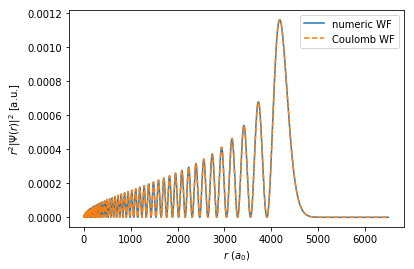

In [7]:
plt.xlabel("$r$ ($a_0$)")
plt.ylabel(r"$r^2|\Psi(r)|^2$ [a.u.]")
plt.plot(n[:, 0] ** 2, np.abs(np.sqrt(n[:, 0]) * n[:, 1]) ** 2, "-", label="numeric WF")
plt.plot(w[:, 0] ** 2, np.abs(w[:, 1]) ** 2, "--", label="Coulomb WF")
plt.legend()
plt.show()